In [ ]:
!pip install transformers datasets accelerate peft
!pip install bitsandbytes



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os, gc, torch

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
gc.collect()
torch.cuda.empty_cache()


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
df_liar = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_train.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_train.csv")

df_train = pd.concat([df_liar, df_fake], ignore_index=True)
df_train = df_train.dropna(subset=["text", "label"])
df_train["label"] = df_train["label"].astype(int)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=df_train["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [ ]:
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(df_train).map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
train_dataset.set_format("torch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Map:   0%|          | 0/10577 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
    device_map="auto"
)

model.gradient_checkpointing_enable()
model.config.use_cache = False


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer
from bitsandbytes.optim import Adam8bit
from transformers.trainer_pt_utils import get_parameter_names

def get_optimizer(model):
    decay_parameters = get_parameter_names(model, [torch.nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]

    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters and p.requires_grad],
            "weight_decay": 0.01,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters and p.requires_grad],
            "weight_decay": 0.0,
        },
    ]
    return Adam8bit(optimizer_grouped_parameters, lr=1e-5)


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").to(torch.long)
        outputs = model(**inputs)
        logits = outputs.logits
        weight = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
training_args = TrainingArguments(
    output_dir="./phi2_output",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    max_grad_norm=1.0,
    fp16=False,
    bf16=False,
    torch_compile=False
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights,
    optimizers=(get_optimizer(model), None)
)
trainer.train()

<ipython-input-10-31041ea34719>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
50,0.801600
100,0.785200
150,0.798000
200,0.714400
250,0.770300
300,0.633100
350,0.722100
400,0.736300
450,0.780800
500,0.729500


TrainOutput(global_step=7932, training_loss=0.5937206404893253, metrics={'train_runtime': 13481.6494, 'train_samples_per_second': 2.354, 'train_steps_per_second': 0.588, 'total_flos': 1.2266486331604992e+17, 'train_loss': 0.5937206404893253, 'epoch': 2.999149097097476})

In [ ]:

from collections import Counter

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id


def load_test_data(path):
    df = pd.read_csv(path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)
    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset = dataset.remove_columns(["text"])
    dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return dataset


test_paths = {
    "LIAR": "/content/drive/MyDrive/misinfo_project/liar/liar_test.csv",
    "FakeNewsNet": "/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv"
}


results = {}
for name, path in test_paths.items():
    print(f"\n🔍 Evaluating on {name} test set...")
    test_dataset = load_test_data(path)
    prediction_output = trainer.predict(test_dataset)

    preds = torch.argmax(torch.tensor(prediction_output.predictions), dim=1)
    labels = prediction_output.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    accuracy = accuracy_score(labels, preds)

    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f"{name} Results:")
    for metric, score in results[name].items():
        print(f"  {metric}: {score:.4f}")
    print("  Class distribution:", dict(Counter(preds.tolist())))



🔍 Evaluating on LIAR test set...


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

LIAR Results:
  accuracy: 0.5896
  precision: 0.4399
  recall: 0.5791
  f1: 0.5000
  Class distribution: {0: 676, 1: 591}

🔍 Evaluating on FakeNewsNet test set...


Map:   0%|          | 0/85 [00:00<?, ? examples/s]

FakeNewsNet Results:
  accuracy: 0.3294
  precision: 0.3469
  recall: 0.4048
  f1: 0.3736
  Class distribution: {1: 49, 0: 36}


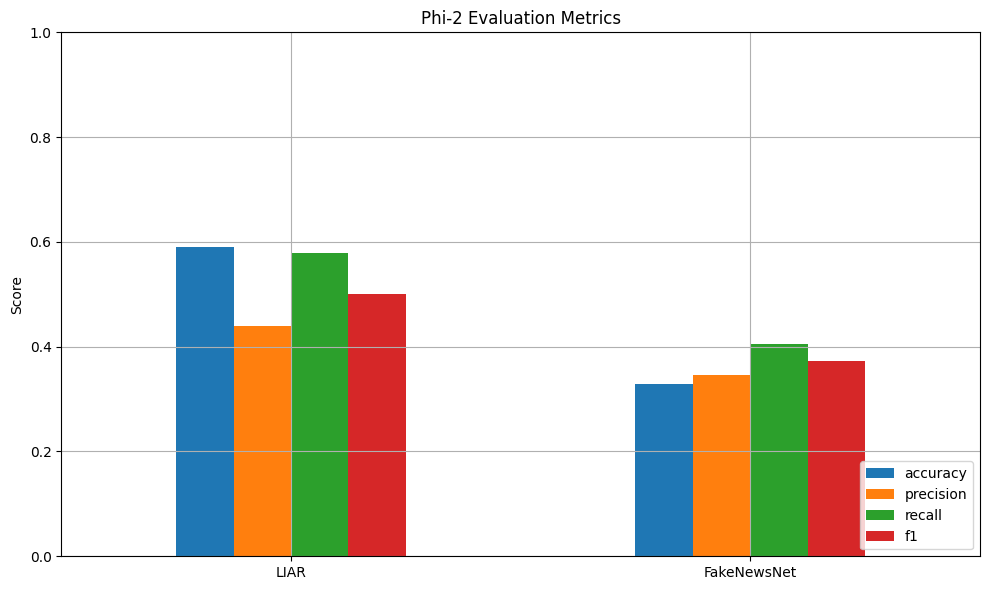

In [ ]:
df_metrics = pd.DataFrame(results).T
df_metrics.plot.bar(figsize=(10, 6))
plt.title("Phi-2 Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/misinfo_project/models/phi2_final"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


('/content/drive/MyDrive/misinfo_project/models/phi2_final/tokenizer_config.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_final/special_tokens_map.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_final/vocab.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_final/merges.txt',
 '/content/drive/MyDrive/misinfo_project/models/phi2_final/added_tokens.json',
 '/content/drive/MyDrive/misinfo_project/models/phi2_final/tokenizer.json')